<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [6]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [7]:
import tensorflow_probability as tfp

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [9]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [10]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'

seed            = 8720

latent_dim      = 10
network_type    = 'fully_connected'

In [11]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [12]:
### load data and join
res_fluxes, res_masks, res_inv_vars = [], [] ,[]
redshifts, SNs, ras, decs, category, sublabel = [], [], [], [], [], []
for nn in range(0,6):
    res_fluxes_, res_masks_, res_inv_vars_ = np.load(os.path.join(root_prepped,'prepped_data_spectra_%s_batch%d.npy'%(label_,nn)))
    redshifts_, SNs_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_ =  np.load(os.path.join(root_prepped,'prepped_data_prop_%s_batch%d.npy'%(label_,nn)))
    if nn==0:
        res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = res_fluxes_, res_masks_, res_inv_vars_, redshifts_, SNs_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_
    else:
        res_fluxes   = np.concatenate([res_fluxes, res_fluxes_],axis=0)
        res_masks    = np.concatenate([res_masks, res_masks_],axis=0)
        res_inv_vars = np.concatenate([res_inv_vars, res_inv_vars_],axis=0)
        redshifts    = np.concatenate([redshifts, redshifts_],axis=0)
        SNs          = np.concatenate([SNs, SNs_],axis=0)
        ras          = np.concatenate([ras, ras_],axis=0)
        decs         = np.concatenate([decs, decs_],axis=0)
        category     = np.concatenate([category, category_],axis=0)
        sublabel     = np.concatenate([sublabel, sublabel_],axis=0)
        MJD          = np.concatenate([MJD, MJD_],axis=0)
        plate_id     = np.concatenate([plate_id, plate_id_],axis=0)
        fiber        = np.concatenate([fiber, fiber_],axis=0)
    print(len(res_fluxes_),nn)
    

88152 0
87988 1
88386 2
87950 3
88034 4
26440 5


In [13]:
for ii in range(5):
    print(MJD[ii], plate_id[ii], fiber[ii], ras[ii], decs[ii], redshifts[ii])

b'53473.0' b'2108.0' b'50.0' b'181.9969024658203' b'37.638492584228516' b'0.10390836745500565'
b'56902.0' b'7616.0' b'941.0' b'11.321800231933594' b'21.414342880249023' b'0.32158181071281433'
b'55955.0' b'5406.0' b'136.0' b'189.802734375' b'9.319830894470215' b'0.08376356214284897'
b'55452.0' b'4085.0' b'107.0' b'322.25970458984375' b'6.486550331115723' b'0.23032799363136292'
b'54540.0' b'2786.0' b'390.0' b'213.32225036621094' b'22.519697189331055' b'0.13797487318515778'


In [14]:
dim = fixed_num_bins

In [53]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask

input        = Input(shape=(dim,1))
input_params = Input(shape=(1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))


if network_type=='fully_connected':
    x = Flatten()(input)
    x = Dense(256)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = Dense(64)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(32)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(16)(x)
    #x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU()(x)
    #x = BatchNormalization(momentum=0.9)(x)
    x = Dense(latent_dim)(x)
    #x = tf.concat([x,input_params],axis=1)
    #z = Flatten()(input_params)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(16)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(32)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(256)(x)
    #x = BatchNormalization(trainable=False)(x)
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(256, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(256, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    #x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    x = LeakyReLU()(x)
    #x = tf.concat([z,input_params], axis=1)
    x = Dense(1024,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((32,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    #x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0][0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}
    
    


In [54]:
tf.random.set_seed(seed)


lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=[],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1000)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          256256      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           16448       dense_10[0][0]                   
_____________________________________________________________________________________

In [55]:
def make_scheduler(length, initial_lr,factor=1.2):
    
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
        
    return scheduler



In [56]:

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.7* DATASET_SIZE)
test_size    = int(0.1 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)
indices      = np.arange(DATASET_SIZE)

In [57]:
np.random.seed(seed)
np.random.shuffle(indices)

In [58]:
def reshuffle(list_, indices):
    res = []
    for item_ in list_:
        res.append(item_[indices])
    return res

In [59]:
res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = reshuffle([res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel,MJD, plate_id, fiber], indices)

In [60]:
int(float(MJD[ii]))

55684

In [61]:
for ii in range(10):
    print('%d,%d,%d'%(int(float(plate_id[ii])), int(float(MJD[ii])), int(float(fiber[ii]))+1))
for ii in range(10):
    print(ras[ii], decs[ii], redshifts[ii])

6273,56243,61
6199,56220,415
6743,56385,423
6155,56245,150
1281,52753,438
4496,55544,183
1466,53083,562
8494,57104,427
4188,55684,164
10232,58223,285
b'33.62675094604492' b'29.20810317993164' b'0.21022766828536987'
b'11.07858943939209' b'17.690685272216797' b'0.23423880338668823'
b'200.77566528320312' b'48.252960205078125' b'0.34074684977531433'
b'348.996826171875' b'11.022068977355957' b'0.2197398692369461'
b'196.84817504882812' b'49.218746185302734' b'0.12573809921741486'
b'127.7883529663086' b'15.518917083740234' b'0.30899083614349365'
b'209.03216552734375' b'45.96754455566406' b'0.12400596588850021'
b'223.87509155273438' b'39.5663948059082' b'0.18365797400474548'
b'248.45729064941406' b'23.53558349609375' b'0.15615500509738922'
b'150.632568359375' b'32.59872817993164' b'0.34561124444007874'


In [62]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    z_array = np.asarray(z_array, dtype=np.float32)
    indx = np.where((z_array>min_z)*(z_array<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = redshift_bin(.1, .36, redshifts, [res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber])

new datasize:  412847


In [63]:
for ii in range(10):
    print('%d,%d,%d'%(int(float(plate_id[ii])), int(float(MJD[ii])), int(float(fiber[ii]))+1))
for ii in range(10):
    print(ras[ii], decs[ii], redshifts[ii])

6273,56243,61
6199,56220,415
6743,56385,423
6155,56245,150
1281,52753,438
4496,55544,183
1466,53083,562
8494,57104,427
4188,55684,164
10232,58223,285
b'33.62675094604492' b'29.20810317993164' b'0.21022766828536987'
b'11.07858943939209' b'17.690685272216797' b'0.23423880338668823'
b'200.77566528320312' b'48.252960205078125' b'0.34074684977531433'
b'348.996826171875' b'11.022068977355957' b'0.2197398692369461'
b'196.84817504882812' b'49.218746185302734' b'0.12573809921741486'
b'127.7883529663086' b'15.518917083740234' b'0.30899083614349365'
b'209.03216552734375' b'45.96754455566406' b'0.12400596588850021'
b'223.87509155273438' b'39.5663948059082' b'0.18365797400474548'
b'248.45729064941406' b'23.53558349609375' b'0.15615500509738922'
b'150.632568359375' b'32.59872817993164' b'0.34561124444007874'


In [64]:
mean=np.mean(res_fluxes)
std = np.std(res_fluxes)

#### if only divide by mean
std = mean
mean= 0

In [65]:
print(std)

205161.48295019302


In [66]:
train_data   = np.expand_dims((res_fluxes[:train_size]-mean)/std,-1)
valid_data   = np.expand_dims((res_fluxes[train_size:train_size+valid_size]-mean)/std,-1)
test_data    = np.expand_dims((res_fluxes[-test_size::]-mean)/std,-1)

train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
test_mask    = np.expand_dims(res_masks[-test_size::],-1)

train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*std**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*std**2
test_noise   = np.expand_dims(res_inv_vars[-test_size::],-1)*std**2

train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]
test_params  = np.asarray(redshifts, dtype=np.float32)[-test_size::]

train_ras = np.asarray(ras, dtype=np.float32)[:train_size]
valid_ras = np.asarray(ras, dtype=np.float32)[train_size:train_size+valid_size]
test_ras  = np.asarray(ras, dtype=np.float32)[-test_size::]

train_decs = np.asarray(decs, dtype=np.float32)[:train_size]
valid_decs = np.asarray(decs, dtype=np.float32)[train_size:train_size+valid_size]
test_decs  = np.asarray(decs, dtype=np.float32)[-test_size::]

train_cat = category[:train_size]
valid_cat = category[train_size:train_size+valid_size]
test_cat  = category[-test_size::]

train_labels = sublabel[:train_size]
valid_labels = sublabel[train_size:train_size+valid_size]
test_labels  = sublabel[-test_size::]


valid_MJD = MJD[train_size:train_size+valid_size]
test_MJD = MJD[-test_size::]

valid_plate_id = plate_id[train_size:train_size+valid_size]
test_plate_id = plate_id[-test_size::]

valid_fiber = fiber[train_size:train_size+valid_size]
test_fiber = fiber[-test_size::]

In [67]:
np.savez(os.path.join(root_model_data,'train_%s.npy'%label_2),np.squeeze(train_data),np.squeeze(train_mask),np.squeeze(train_noise),train_params,train_ras, train_decs, train_cat, train_labels)

In [68]:
np.savez(os.path.join(root_model_data,'valid_%s.npy'%label_2),np.squeeze(valid_data),np.squeeze(valid_mask),np.squeeze(valid_noise),valid_params,valid_ras, valid_decs, valid_cat, valid_labels, valid_MJD, valid_plate_id, valid_fiber)

In [69]:
np.savez(os.path.join(root_model_data,'test_%s.npy'%label_2),np.squeeze(test_data),np.squeeze(test_mask),np.squeeze(test_noise),test_params,test_ras, test_decs, test_cat, test_labels, test_MJD, test_plate_id, test_fiber)

In [70]:
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback])
    return history

In [71]:
def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [72]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train_data[0]))
    metrics = []
    for ii in range(10):
        print(ii)
        sample = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train_data[0][sample],train_data[1][sample],train_data[2][sample], train_data[3][sample]))
        metric    = custom_metric((train_data[0][sample],train_data[1][sample],train_data[2][sample], train_data[3][sample]),res_train)
        metrics.append(metric)
    return metrics

In [74]:
histories =[]
for batchsize, nepochs, lr_ann in zip([32],[20],[15]):
    histories.append(training_cycle(batchsize, nepochs, lr_ann, 1e-3, 0.5))
    res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))
    print(custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid))
    res_train = lstm_ae.predict((train_data[:len(valid_data)],train_mask[:len(valid_data)],train_noise[:len(valid_data)], train_params[:len(valid_data)]))
    print(custom_metric((train_data[:len(valid_data)],train_mask[:len(valid_data)],train_noise[:len(valid_data)], train_params[:len(valid_data)]),res_train))

KeyboardInterrupt: 

In [75]:
res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))

In [76]:
custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid)

1.2888870705666342

In [77]:
bootstrap([train_data,train_mask,train_noise, train_params], batch_size=len(valid_data))

0
1
2
3
4
5
6
7
8
9


[1.2451489366249344,
 1.24534638028302,
 1.2458180680373767,
 1.252131567737902,
 1.2496997737871864,
 1.2475839715688497,
 1.2504655535519158,
 1.2486813982258558,
 1.2506309812052794,
 1.2506061133178865]

In [78]:
# plt.plot(np.append(histories[0].history['training_loss'],histories[1].history['training_loss']))
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [79]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(curr_layer)
        new_model.add(curr_layer)
    return new_model

In [80]:
encoder = extract_layers(lstm_ae,1,10)

decoder = extract_layers(lstm_ae,10,22)

In [81]:
encoder.build((None,fixed_num_bins))
decoder.build((None,latent_dim))

In [82]:
encoder.summary()
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)               

In [83]:
encoded_valid = encoder.predict(valid_data)
encoded_train = encoder.predict(train_data)
encoded_test = encoder.predict(test_data)

In [84]:
decoded_valid = decoder.predict(encoded_valid)
decoded_train = decoder.predict(encoded_train)
decoded_test = decoder.predict(encoded_test)

In [85]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder.save(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div


In [86]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder = tf.keras.models.load_model(path)

In [87]:
np.save(os.path.join(root_encoded,'encoded_%s.npy'%label_2),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)

In [88]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test, mean])

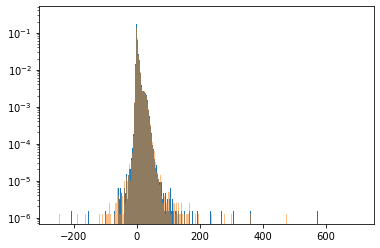

In [89]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [90]:
len(encoded_valid)

82569

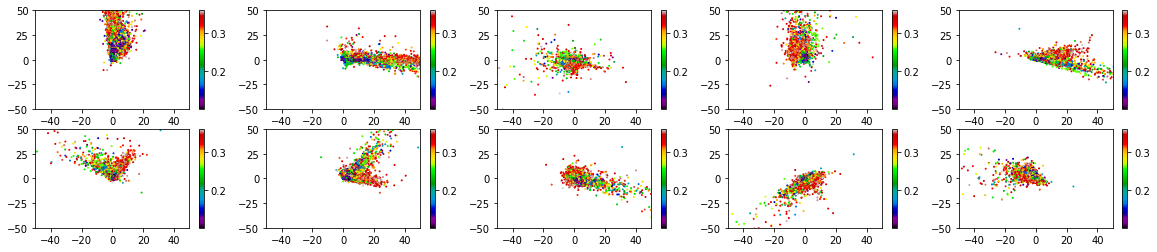

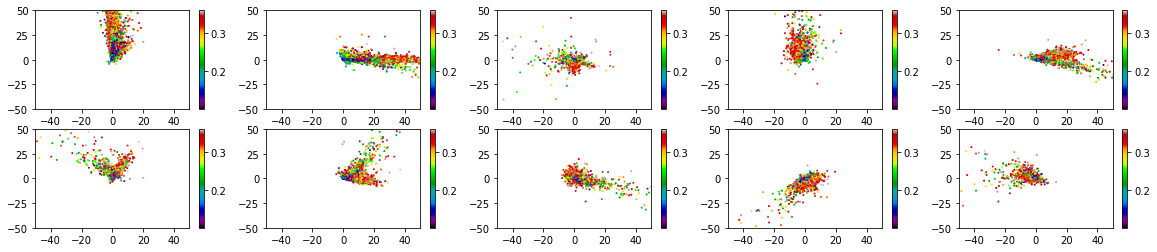

In [94]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_params, cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:47000,ii],encoded_train[:47000,jj],c=train_params[:47000], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [95]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sublabel)
print(le.classes_, le.transform(le.classes_))

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


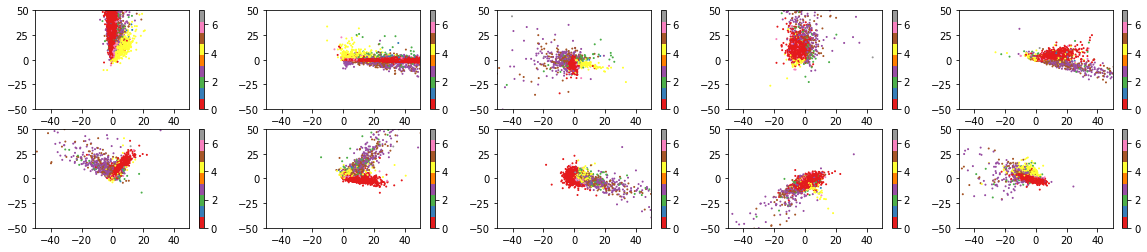

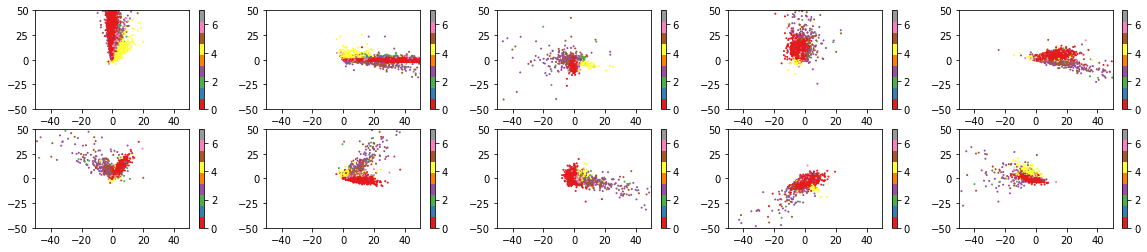

In [96]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=le.transform(valid_labels), cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:47000,ii],encoded_train[:47000,jj],c=le.transform(train_labels)[:47000], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

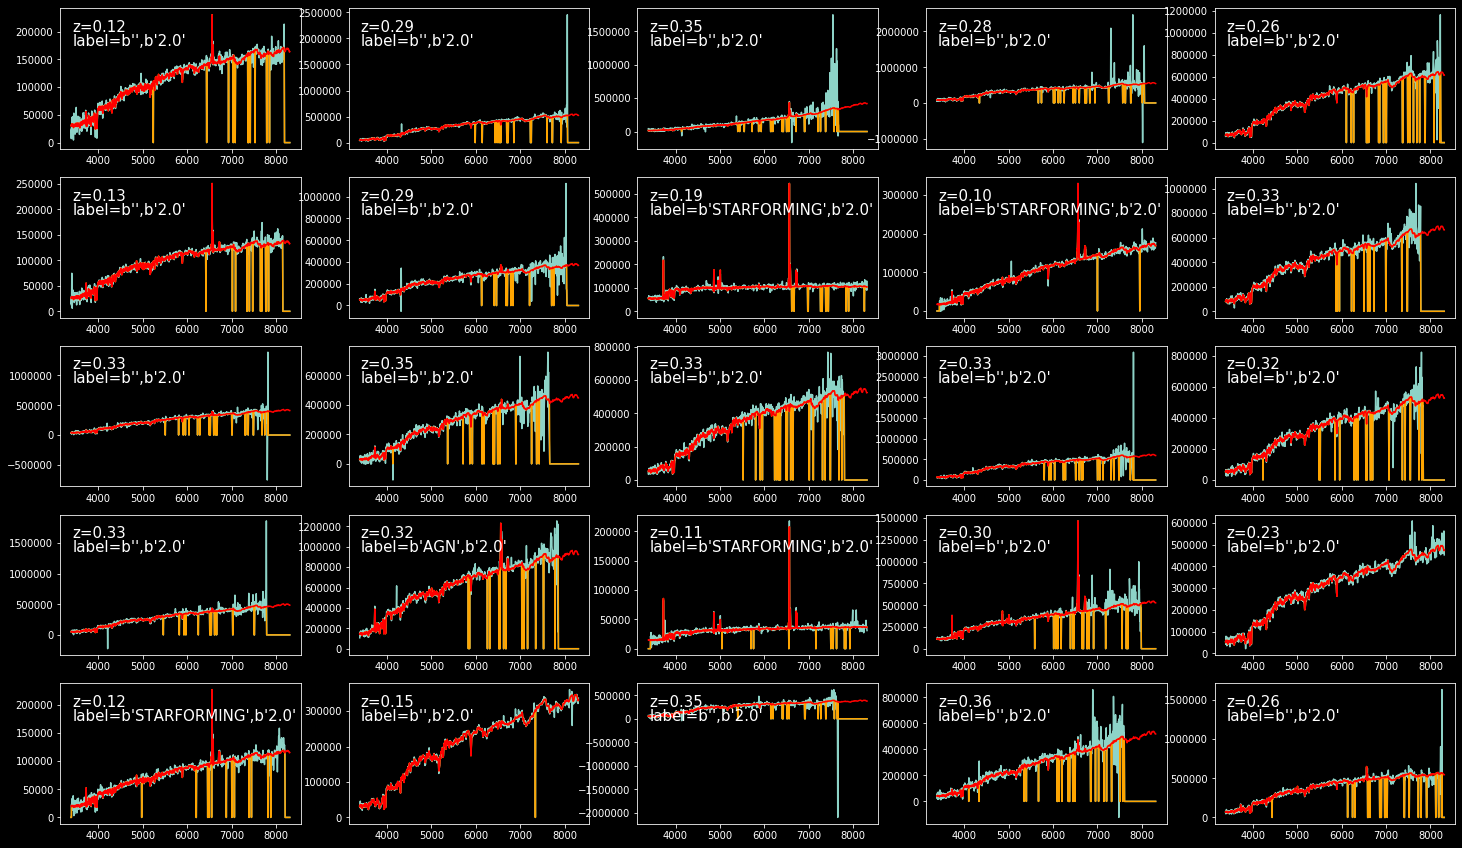

In [97]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data*std)[ii]+mean)*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*std)[ii]+mean)*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*std)[ii]+mean), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid_labels[ii],valid_cat[ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

In [98]:
enc = encoder.predict(train_data)

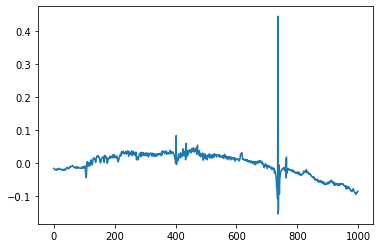

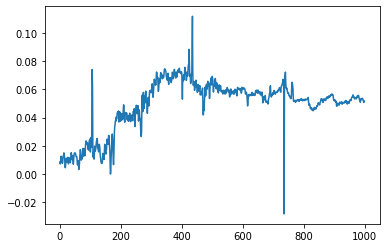

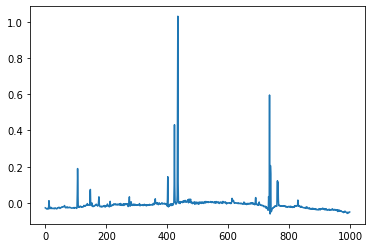

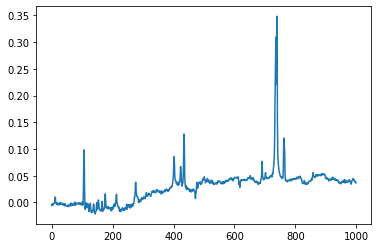

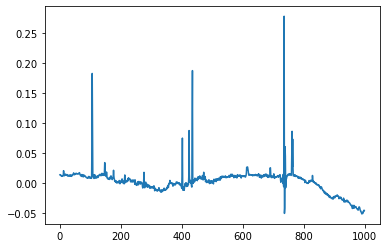

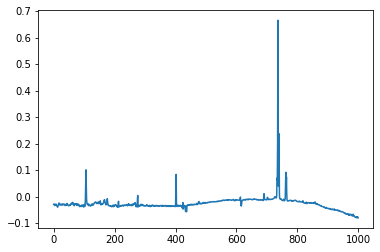

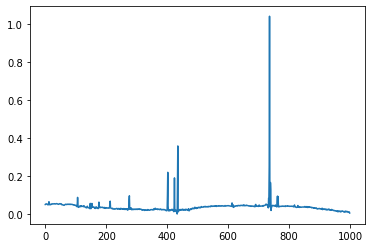

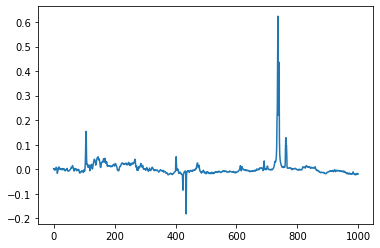

In [99]:
sens=[]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]+=1
    sens+=[res]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]-=1
    sens+=[res]
sens+=[np.mean(enc,axis=0)]
sens = np.asarray(sens)
test = decoder.predict(sens)

for ii in range(8):
    plt.plot(test[ii]-test[8+ii])
    plt.show()